In [1]:
import sys
import os
import numpy as np
from scipy.optimize import curve_fit
import random
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pdb #python debugger
from timeit import default_timer as timer #timer
from collections import OrderedDict
import importlib
sys.path.insert(1, '/Users/ryanlopez/ABPTutorial/c++') #Connects to ABP Folder github.com/ryanlopezzzz/ABPTutorial
from cppmd.builder import *
import cppmd as md
import read_data as rd #reads snapshot text data
import directories #used to create directories for saving data
import Physical_Quantities.vorticity as vorticity
import Physical_Quantities.fourier_calculations as fc
importlib.reload(vorticity)
importlib.reload(fc)

<module 'Physical_Quantities.fourier_calculations' from '/Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/ABP/Physical_Quantities/fourier_calculations.py'>

# Load Simulation Data

In [100]:
#Directory where all data is saved
save_dir = "/Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/Saved_Data"
exp_folder_name = "Vary_Dr_and_phi=0.50" #Folder name of experiment directory
exp_dir = os.path.join(save_dir, exp_folder_name)

varied_values = []
vicsek_values = []
velocity_values = []
dir_dot_vel_values = []
dir_dot_vel_norm_values = []
v_mag_data_values = []
exp_data = []

for f in os.scandir(exp_dir): #runs through all immediate subdirectories
    if f.is_dir() and f.path != os.path.join(exp_dir, ".ipynb_checkpoints"):
        run_desc_file = open(os.path.join(f, 'run_desc.json'))
        run_desc = json.loads(run_desc_file.read())
        run_desc_file.close()

        varied_values.append(run_desc['D_r'])
        vicsek_values.append(run_desc['vicsek_param'])
        velocity_values.append(run_desc['vel_param'])
        dir_dot_vel = np.load(os.path.join(f, "dir_dot_vel.npy"))
        dir_dot_vel_values.append(np.average(dir_dot_vel))
        dir_dot_vel_norm = np.load(os.path.join(f, "dir_dot_vel_norm.npy"))
        dir_dot_vel_norm_values.append(np.average(dir_dot_vel_norm))
        v_mag_data = np.load(os.path.join(f, "v_mag_data.npy"))
        v_mag_data = v_mag_data.flatten()
        v_mag_data_values.append(v_mag_data)
        exp_data.append(rd.get_exp_data(os.path.join(f, 'snapshot_data')))

In [101]:
print(varied_values)

[0.15, 0.09, 0.06, 0.2, 0.11, 0.02, 0.01, 0.12, 0.05, 0.16, 0.19, 0.03, 0.1, 0.07, 0.08, 0.14, 0.18, 0.17, 0.04, 0.13, 0.0]


In [102]:
view_index = 12

# Vicsek Order Parameter

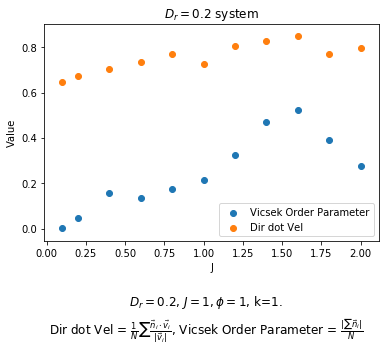

In [50]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
#ax.set_xlim(1e-3, 2.5)
ax.scatter(varied_values, vicsek_values, label = "Vicsek Order Parameter")
ax.scatter(varied_values, dir_dot_vel_norm_values, label = "Dir dot Vel")

ax.set(xlabel=r'J', ylabel='Value',
       title=r'$D_r = 0.2$ system')
ax.legend()

fig.text(.5, -.1, r"$D_r= 0.2$, $J=1, \phi=1$, k=1.", ha='center', fontsize=12)
fig.text(.5, -.2, r"Dir dot Vel = $\frac{1}{N}\sum \frac{\vec{n}_i \cdot \vec{v}_i}{\left|\vec{v}_i \right|}$, Vicsek Order Parameter = $\frac{ \left| \sum \vec{n}_i \right|}{N}$", ha='center', fontsize=12)

plt.show()

# Velocity Distribution

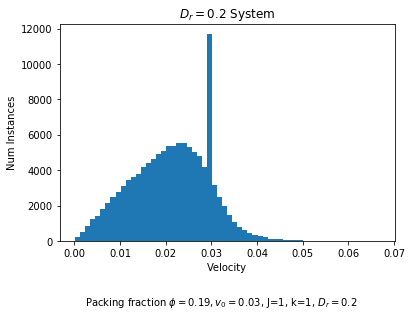

In [6]:
fig, ax = plt.subplots()
ax.hist(v_mag_data_values[view_index], bins=60)

ax.set(xlabel=r'Velocity', ylabel='Num Instances',
       title=r'$D_r=0.2$ System')

fig.text(.5, -.1, r"Packing fraction $\phi= %.2f, v_0=0.03$, J=1, k=1, $D_r=0.2$"%(varied_values[view_index]), ha='center')

plt.show()

# Vorticity

In [103]:
"""
Note this density calculation does not include polydispersity
"""
snapshot_num = 67 #which time snapshot to look at 

density_limit = 0.95

L=70
radius=1
x = np.linspace(-L/2, L/2, num=10) #defines bins
y = np.linspace(-L/2, L/2, num=10)

x_pos_data = exp_data[view_index]['x'][snapshot_num]
y_pos_data = exp_data[view_index]['y'][snapshot_num]

particle_density, xedges, yedges = np.histogram2d(x_pos_data, y_pos_data, bins=(x, y))
particle_density = particle_density.T
particle_density = particle_density * (np.pi*radius**2) / ((x[1]-x[0])*(y[1]-y[0]))

#Determines if should be zero by looking at neighbors too
particle_density+=np.roll(particle_density,1,axis=0)+np.roll(particle_density,-1,axis=0)+np.roll(particle_density,1,axis=1)+np.roll(particle_density,-1,axis=1)
particle_density[particle_density < 5*density_limit] = 0
particle_density[particle_density >= 5*density_limit] = 1

In [104]:
x_center = (x+(x[1]-x[0])/2)[:-1]
y_center = (y+(y[1]-y[0])/2)[:-1]
h=2

X, Y = np.meshgrid(x_center,y_center)
vorticity_grid = vorticity.get_vorticity(exp_data[view_index], x_center, y_center, h, L,
                                         vec_field='director', include_density=True)
vorticity_grid = np.nan_to_num(vorticity_grid) #Converts all NaN to 0

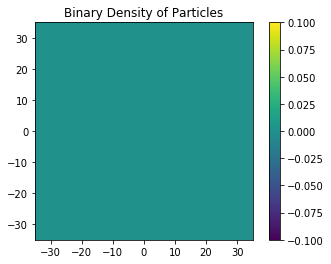

In [105]:
fig, ax = plt.subplots()
Xedges, Yedges = np.meshgrid(xedges, yedges)
plot = ax.pcolormesh(Xedges,Yedges,particle_density)
ax.set_aspect('equal')
ax.set_title('Binary Density of Particles')
plt.colorbar(plot)
plt.show()

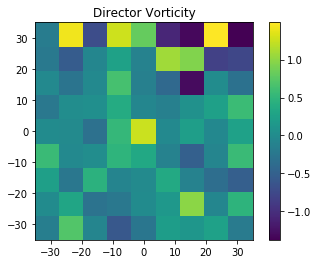

In [106]:
fig, ax = plt.subplots()
plot = ax.pcolormesh(Xedges,Yedges,vorticity_grid[snapshot_num])
ax.set_aspect('equal')
ax.set_title('Director Vorticity')
plt.colorbar(plot)
plt.show()

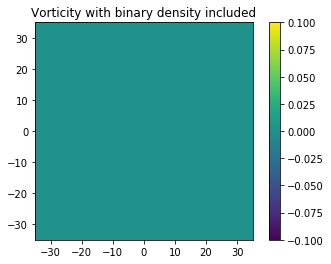

In [107]:
fig, ax = plt.subplots()
plot = ax.pcolormesh(Xedges,Yedges,particle_density*vorticity_grid[snapshot_num])
ax.set_aspect('equal')
ax.set_title('Vorticity with binary density included')
plt.colorbar(plot)
plt.show()

/Users/ryanlopez/opt/anaconda3/envs/ABP/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


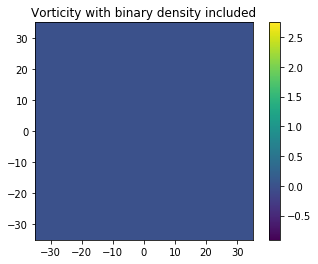

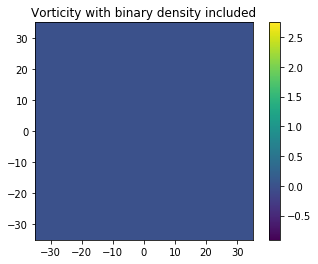

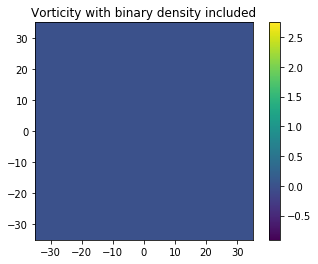

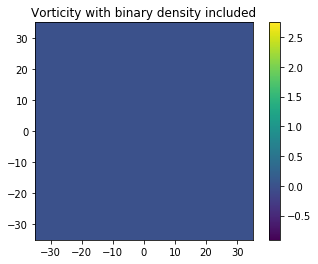

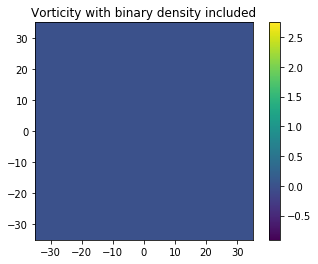

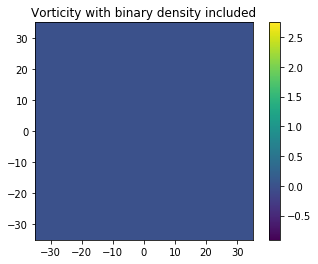

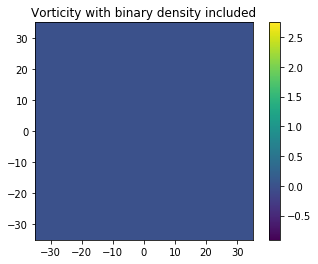

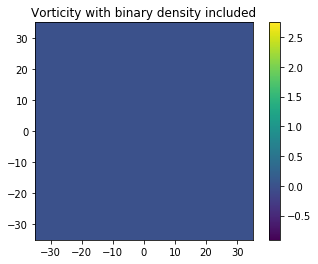

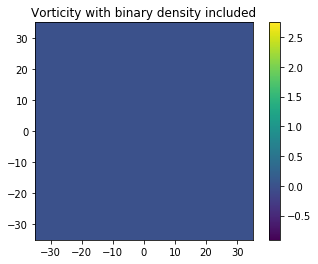

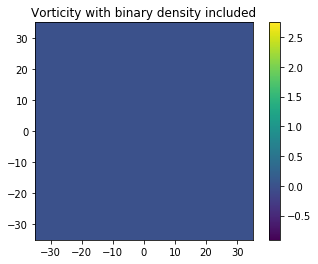

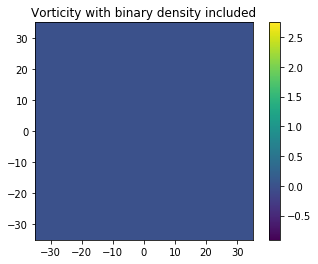

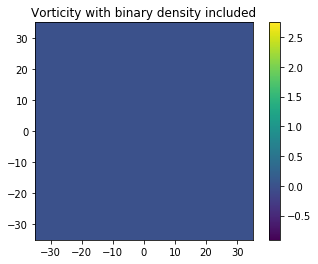

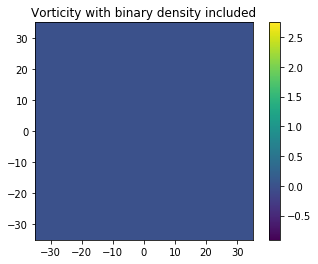

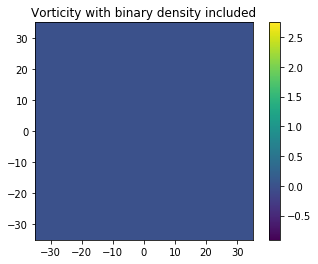

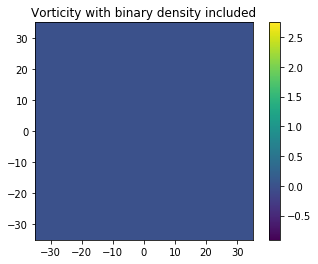

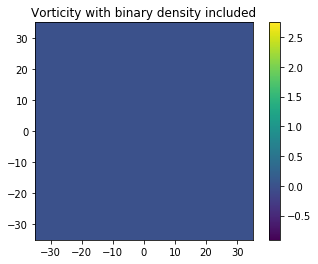

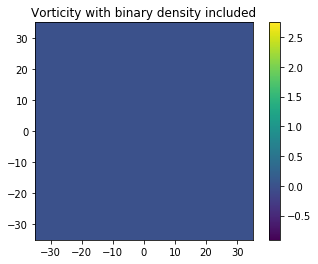

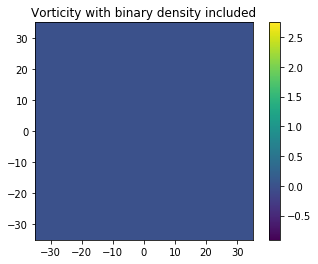

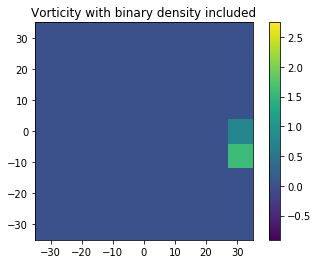

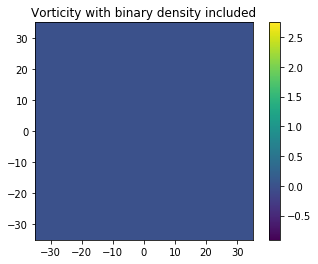

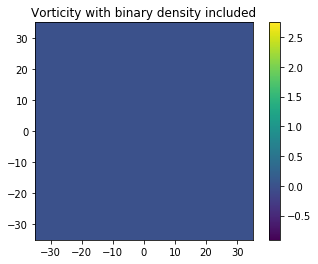

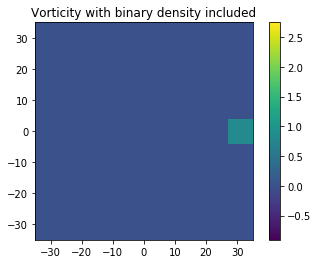

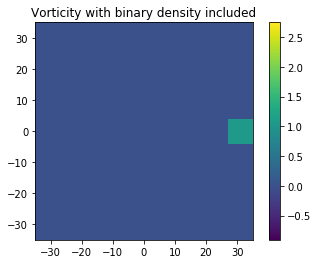

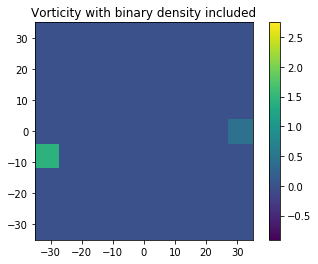

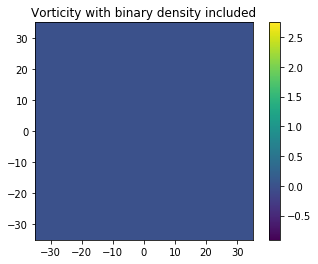

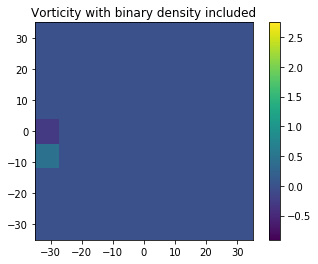

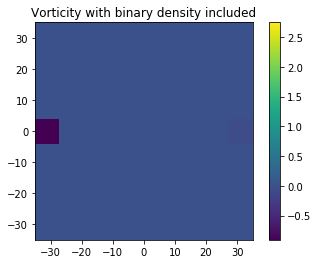

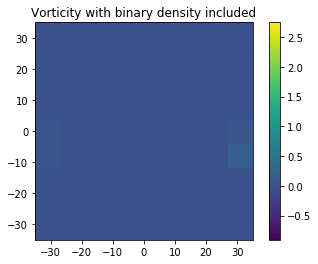

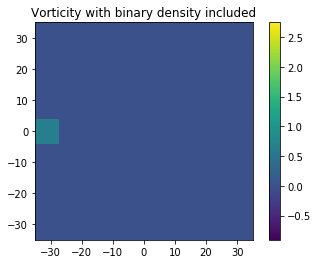

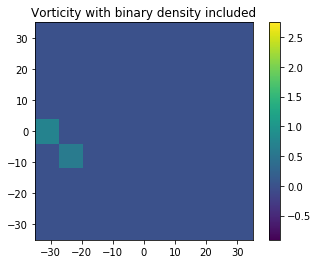

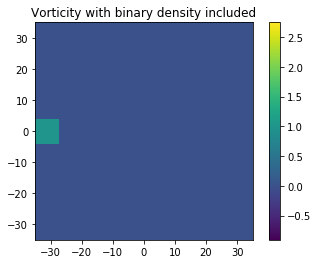

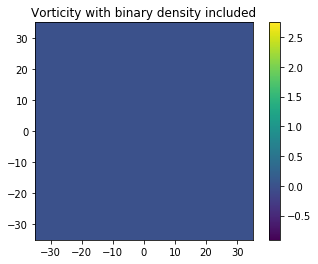

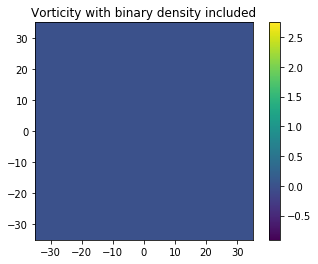

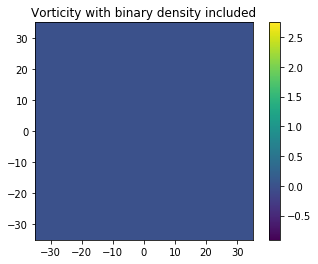

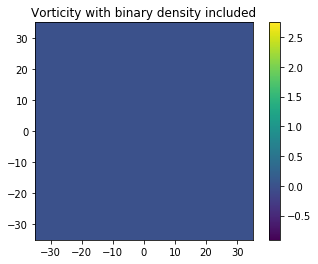

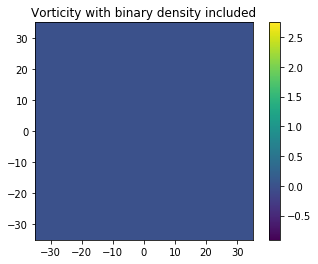

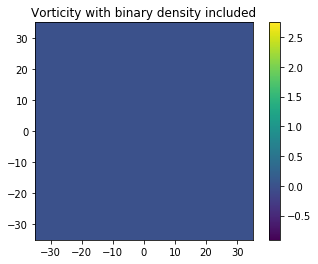

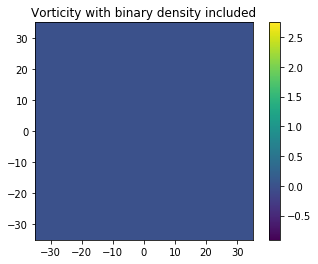

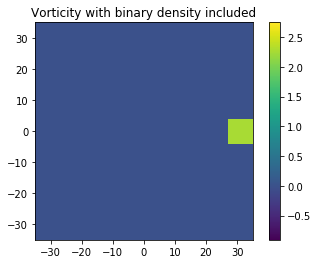

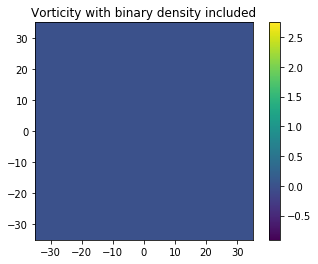

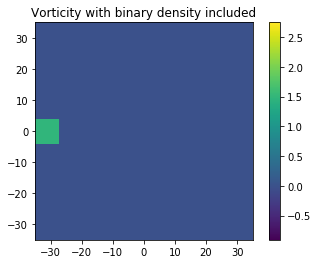

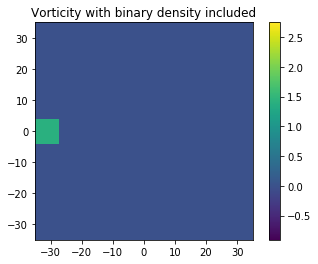

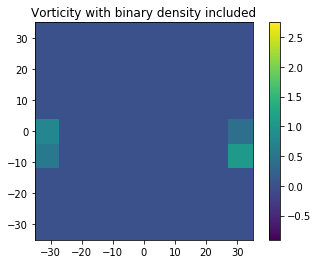

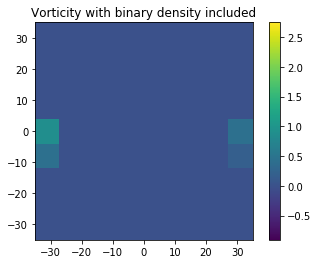

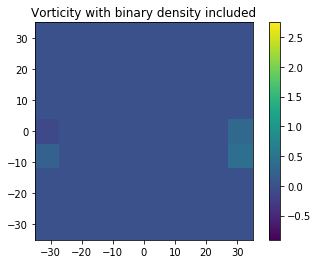

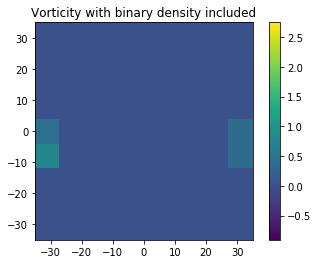

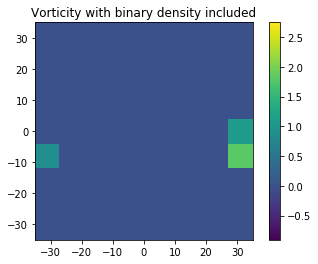

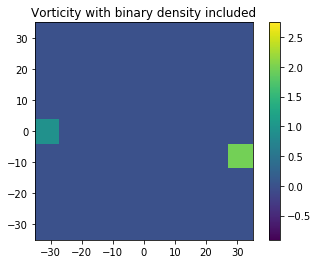

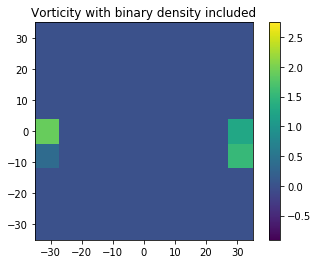

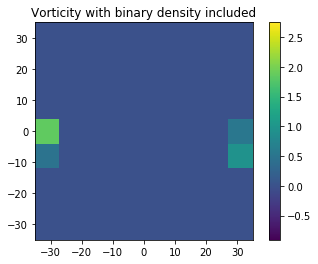

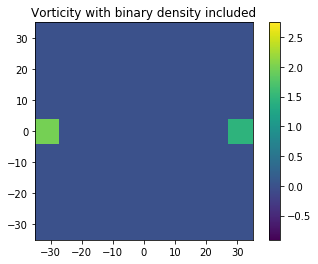

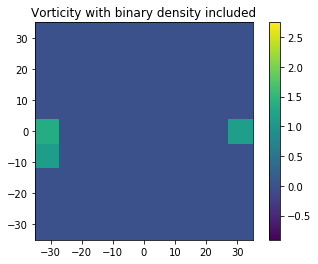

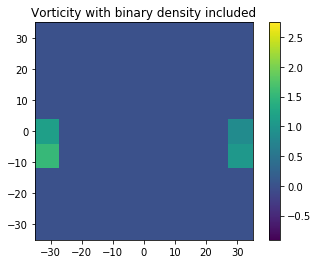

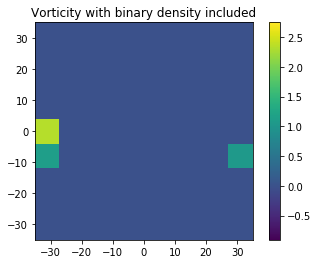

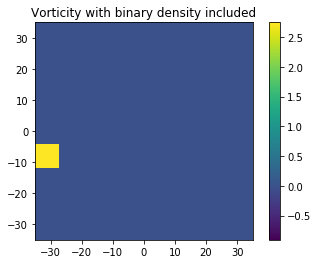

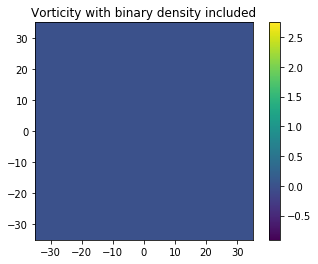

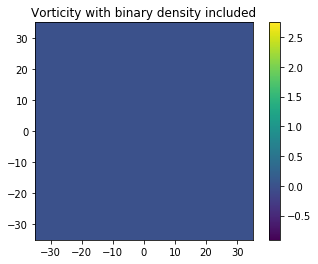

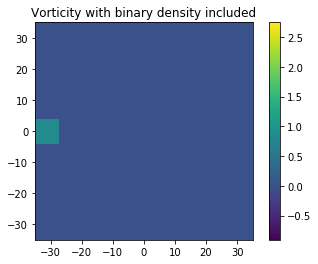

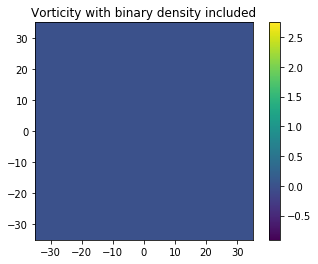

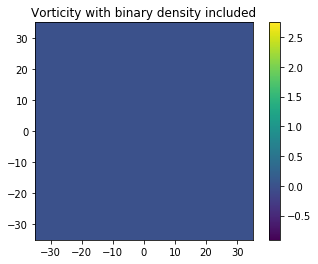

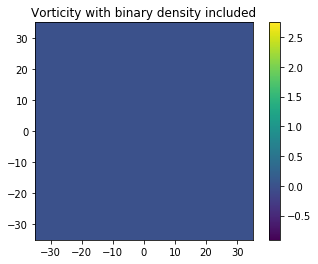

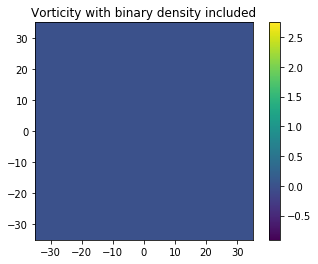

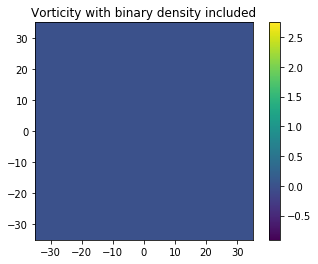

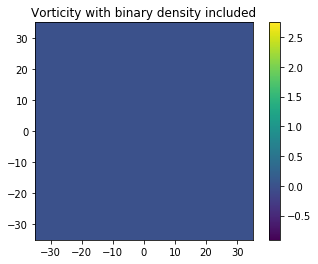

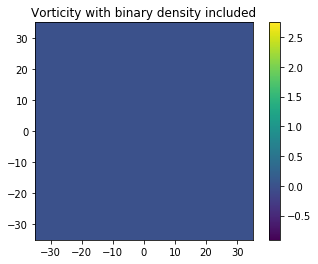

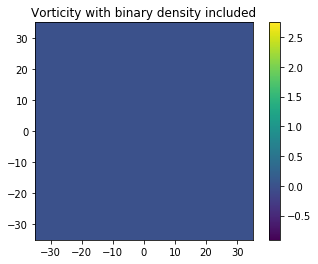

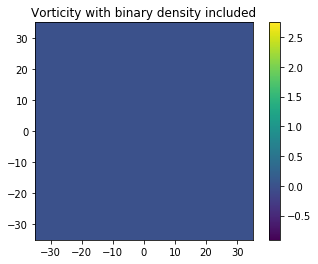

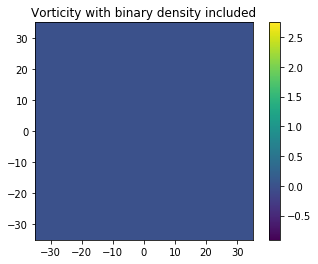

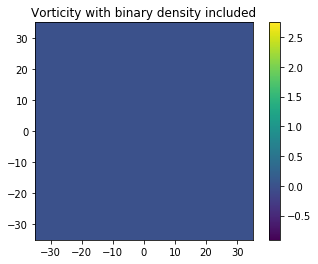

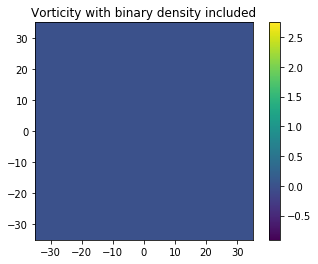

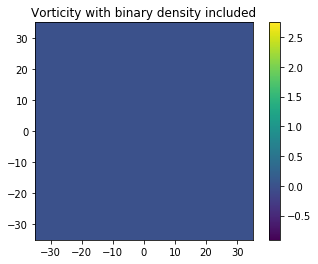

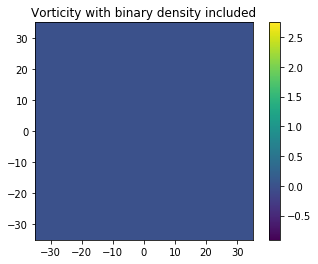

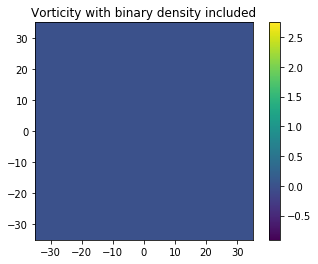

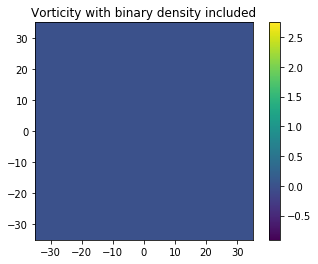

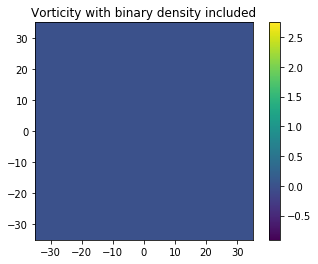

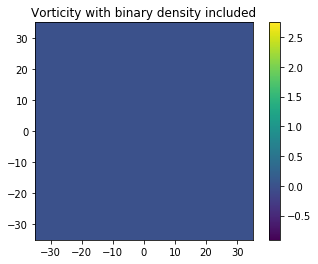

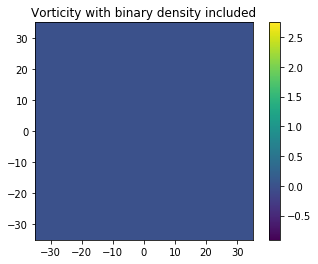

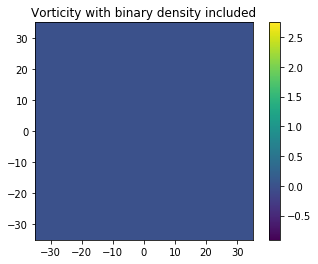

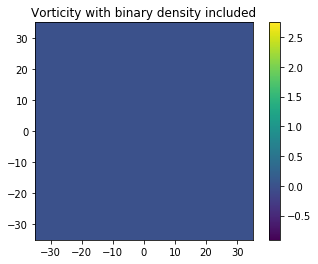

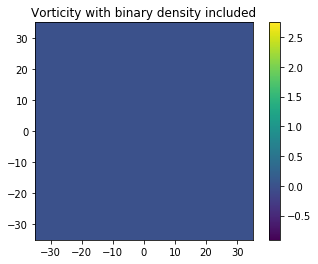

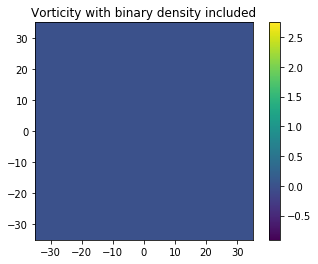

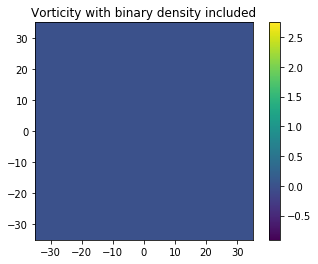

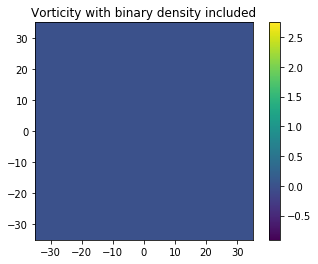

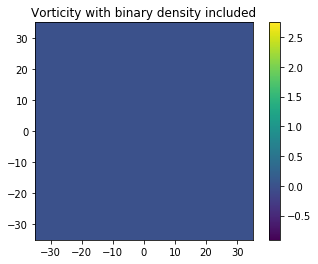

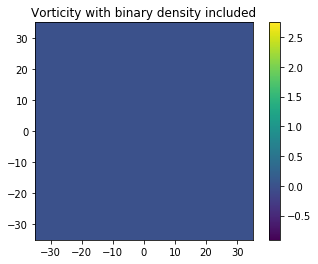

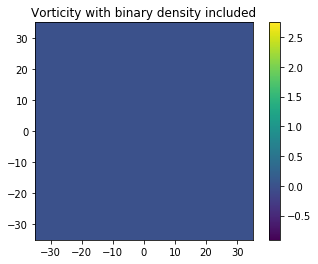

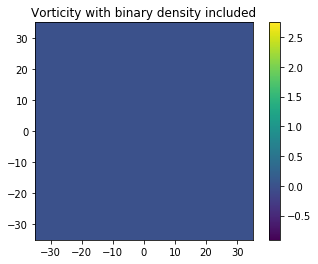

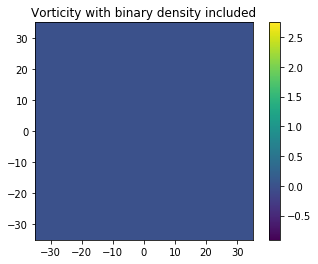

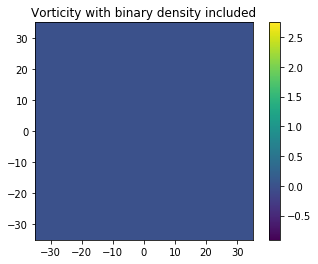

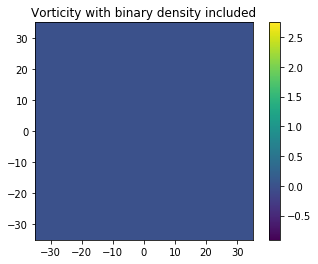

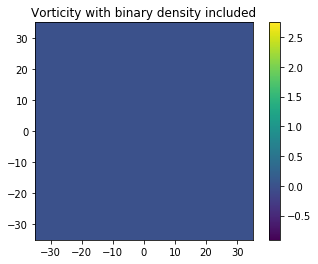

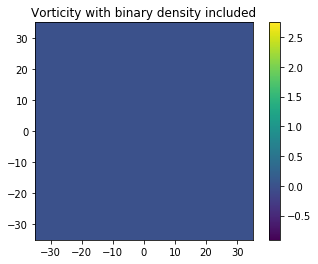

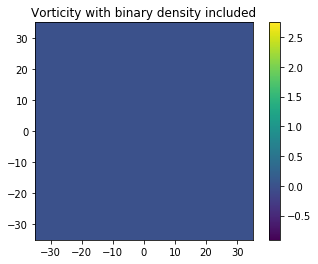

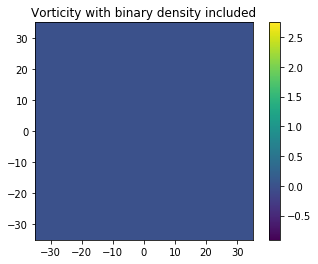

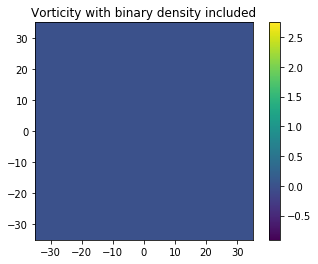

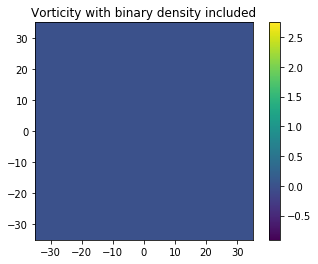

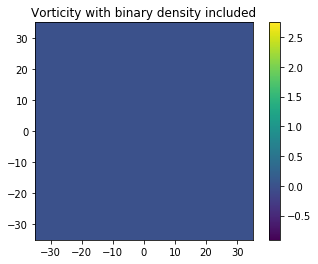

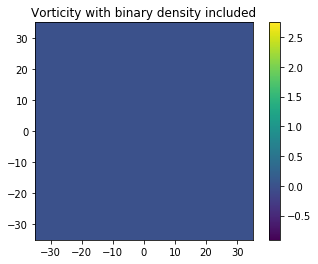

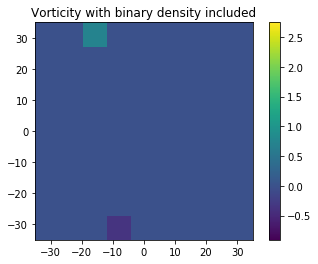

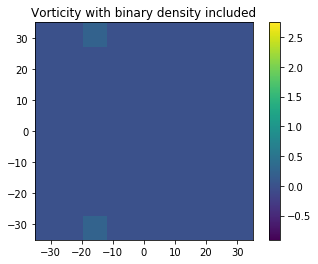

In [110]:
"""
Does similar to above for all snapshots, saves vorticity grid at each snapshot to make movie.
"""
num_snapshots = 100
density_limit = 1

folder_name='director_phi=1'

img_folder = os.path.join(save_dir, 'vorticity_images', folder_name)
os.mkdir(img_folder)

particle_densities = []
for snapshot_num in range(num_snapshots):
    x_pos_data = exp_data[view_index]['x'][snapshot_num]
    y_pos_data = exp_data[view_index]['y'][snapshot_num]

    particle_density, xedges, yedges = np.histogram2d(x_pos_data, y_pos_data, bins=(x, y))
    particle_density = particle_density.T
    particle_density = particle_density * (np.pi*radius**2) / ((x[1]-x[0])*(y[1]-y[0]))

    #Determines if should be zero by looking at neighbors too
    particle_density+=np.roll(particle_density,1,axis=0)+np.roll(particle_density,-1,axis=0)+np.roll(particle_density,1,axis=1)+np.roll(particle_density,-1,axis=1)
    particle_density[particle_density < 5*density_limit] = 0
    particle_density[particle_density >= 5*density_limit] = 1
    particle_densities.append(particle_density)
particle_densities = np.array(particle_densities)
final_vorticity_grids = particle_densities*vorticity_grid
vmin, vmax = np.amin(final_vorticity_grids), np.amax(final_vorticity_grids)
    
for snapshot_num in range(num_snapshots):   
    x_center = (x+(x[1]-x[0])/2)[:-1]
    y_center = (y+(y[1]-y[0])/2)[:-1]

    X, Y = np.meshgrid(x_center,y_center)
    
    fig, ax = plt.subplots()
    plot = ax.pcolormesh(Xedges,Yedges,final_vorticity_grids[snapshot_num], vmin=vmin, vmax=vmax)
    ax.set_aspect('equal')
    ax.set_title('Vorticity with binary density included')
    plt.colorbar(plot)
    #plt.show()
    plt.savefig(os.path.join(img_folder, 'image%.4d'%snapshot_num))

# Static Structure Factor

In [34]:
quantity = np.full(exp_data[view_index]['x'][0,None,:].shape, 1) #All 1 value for static structure factor
exp_data_reduced = {} #only keeps last time snapshot
for key in exp_data[view_index]:    
    exp_data_reduced[key] = exp_data[view_index][key][-1,None,:]    

In [35]:
#wavelength_powers, bins = fc.calculate_fourier(quantity, exp_data[view_index], L=70 , min_wave_length=5, num_bins=24,
#                                              debug=False)
wavelength_powers, bins = fc.calculate_fourier(quantity, exp_data_reduced, L=70 , min_wave_length=1, num_bins=24,
                                              debug=False)

1560


In [36]:
bin_centers = []
for i in range(len(bins)-1):
    bin_centers.append((bins[i]+bins[i+1]) / 2.0)
bin_centers = np.array(bin_centers)

In [37]:
"""
def ssf(q, nu):
    return q**(-nu)
popt, pcov = curve_fit(ssf, bin_centers, wavelength_powers)
print('nu=', popt[0])
"""
popt={}
popt[0] = -1000

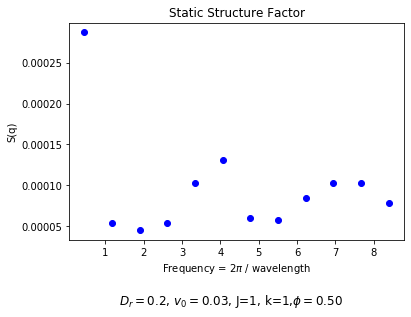

In [48]:
fig, ax = plt.subplots()
ax.plot(bin_centers, wavelength_powers, 'bo')
#ax.plot(bin_centers, ssf(bin_centers, *popt))
ax.set(xlabel=r'Frequency = $2 \pi$ / wavelength', ylabel='S(q)', title='Static Structure Factor')
ax.set_yscale('log')
fig.text(.5, -.1, r"$D_r= 0.2$, $v_0=0.03$, J=1, k=1,$\phi=%.2f$"%(varied_values[view_index]), ha='center', fontsize=12)
plt.show()

# Fourier Space Velocity Correlations

In [39]:
#Can sum vx^2 and vy^2 from linearity of average
quantity_vx = exp_data_reduced['vx']
quantity_vy = exp_data_reduced['vy']

#Subtract average velocity in flocking
quantity_vx -=np.average(quantity_vx, axis=-1)[:,None]
quantity_vy -= np.average(quantity_vy, axis=-1)[:,None]

wavelength_powers_vx, bins = fc.calculate_fourier(quantity_vx, exp_data_reduced, L=70 , min_wave_length=1, num_bins=12)
wavelength_powers_vy, bins = fc.calculate_fourier(quantity_vy, exp_data_reduced, L=70 , min_wave_length=1, num_bins=12)

wavelength_powers = wavelength_powers_vx + wavelength_powers_vy

1560
1560


In [40]:
bin_centers = []
for i in range(len(bins)-1):
    bin_centers.append((bins[i]+bins[i+1]) / 2.0)
bin_centers = np.array(bin_centers)

In [41]:
Np = 1 #Num of particles
v0 = 0.03
def vcf(q, xi):
    return Np*v0**2/(1+(xi*q)**2)
popt, pcov = curve_fit(vcf, bin_centers, wavelength_powers)
print(r'Correlation Length \xi=', popt[0])

Correlation Length \xi= 3.1191608019579244


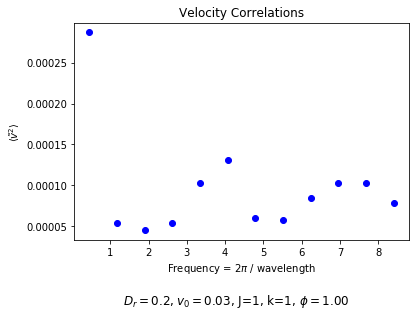

In [42]:
fig, ax = plt.subplots()
ax.plot(bin_centers,wavelength_powers, 'bo')
#ax.plot(bin_centers, vcf(bin_centers, *popt))
ax.set(xlabel=r'Frequency = $2 \pi$ / wavelength', ylabel=r'$\left< \tilde{v}^2 \right>$', title='Velocity Correlations')
#fig.text(.5, -.1, r"$D_r= 0.2$, $v_0=0.03$, J=1, k=1, $\phi=$%.2f, $\xi=$%.2f"%(varied_values[view_index],popt[0]), ha='center', fontsize=12)
fig.text(.5, -.1, r"$D_r= 0.2, v_0=0.03$, J=1, k=1, $\phi=%.2f$"%(varied_values[view_index]), ha='center', fontsize=12)

plt.show()

# Fourier Space Director Correlations

In [ ]:
#Can sum vx^2 and vy^2 from linearity of average
quantity_nx = exp_data[view_index]['nx']
wavelength_powers_nx, bins = fc.calculate_fourier(quantity_nx, exp_data[view_index], L=70 , min_wave_length=5, num_bins=12)

quantity_ny = exp_data[view_index]['ny']
wavelength_powers_ny, bins = fc.calculate_fourier(quantity_ny, exp_data[view_index], L=70 , min_wave_length=5, num_bins=12)

wavelength_powers = wavelength_powers_nx + wavelength_powers_ny

In [ ]:
bin_centers = []
for i in range(len(bins)-1):
    bin_centers.append((bins[i]+bins[i+1]) / 2.0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(bin_centers,wavelength_powers, 'bo')
ax.set(xlabel=r'Frequency = $2 \pi$ / wavelength', ylabel=r'$\left< \tilde{n}^2 \right>$', title='Director Correlations')
fig.text(.5, -.1, r"$D_r= 0.2$, $v_0=0.03$, J=1, k=1,$\phi=$%.2f"%varied_values[view_index], ha='center', fontsize=12)
plt.show()